# An Analysis of Indices of Multiple Deprivation and AHAH Data in Greater Manchester

## 1.0 Introduction

This computational essay runs through an exploration of factors influencing health across Lower-layer Super Output Areas (LSOAs) in Greater Manchester, UK.

Sources of data are [Index of Multiple Deprivation](https://data.cdrc.ac.uk/dataset/cdrc-2015-english-indices-of-deprivation-geodata-pack-greater-manchester-e37000015) data from Greater Manchester combined with [Access to Healthy Assets and Hazards](https://data.cdrc.ac.uk/dataset/access-to-healthy-assets-and-hazards-ahah/resource/f19c4fb3-b6fb-4c51-96fd-08be029ee6c1) data; a multi-dimensional index for assessing how healthy a neighbourhood is.

Both datasets were downloaded from the CDRC website.

## 2.0 Pre-analysis Data Preparation

First, we will import all the libraries we'll need.

In [1]:
#Set matplotlib to display plots within the notebook below the code.
%matplotlib inline 

#Import Geopandas, regular pandas, matplotlib.pyplot and Seaborn
import geopandas as gpd #dataframes with spatial information library
import pandas as pd #dataframe manipulation and analysis
import matplotlib.pyplot as plt #plotting graphics
import seaborn as sns #statistical visualisation library

import statsmodels.formula.api as sm
import numpy as np 
from sklearn import cluster, metrics 
from sklearn.preprocessing import scale
from sklearn import preprocessing 
from sklearn import model_selection
from sklearn.ensemble import RandomForestRegressor

The first data source we'll examine is the IMD data with geometries of the LSOAs.

In [2]:
#Open a spatial data file as a geodataframe with Geopandas
map = gpd.GeoDataFrame.from_file('E37000015_domain.shp')

We'll plot the geometry of the geodataframe to check it looks as we expect it to.

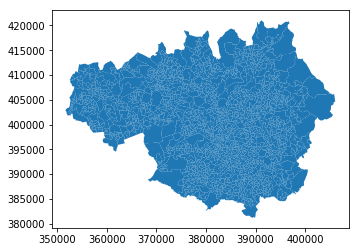

In [3]:
#plot a basic map of the gdf's geometry
map.plot();

It is helpful to know how many variables and observations or 'cases' the geodataframe holds. The `.shape` instruction returns this.

In [4]:
#Examine how many rows and columns are in the geodataframe
map.shape

(1673, 18)

The *map* geodataframe contains 1673 rows and 18 columns, and can examine what data types it holds using the `.info()` command. By passing the optional argument `null_counts=True` to the `.info()` method we can check if for any missing values within the data.

In [5]:
#Examine the type and count of the variables in the geodataframe
map.info(null_counts=True)

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1673 entries, 0 to 1672
Data columns (total 18 columns):
lsoa11cd     1673 non-null object
imd_r        1673 non-null float64
imd_d        1673 non-null float64
income_r     1673 non-null float64
income_d     1673 non-null float64
empl_r       1673 non-null float64
empl_d       1673 non-null float64
educ_r       1673 non-null float64
educ_d       1673 non-null float64
health_r     1673 non-null float64
health_d     1673 non-null float64
crime_r      1673 non-null float64
crime_d      1673 non-null float64
housing_r    1673 non-null float64
housing_d    1673 non-null float64
l_env_r      1673 non-null float64
l_env_d      1673 non-null float64
geometry     1673 non-null object
dtypes: float64(16), object(2)
memory usage: 235.3+ KB


In Pandas, a column with a mix of numbers and strings will be recognised as an object. In the `map` dataframe, the `lsoa11cd` and `geometry` variables are read as objects, while the numerical variables are read as the data type `non-null float64` as they may hold numeric characters with decimals or be a mix of numbers and NaNs (no data). We can see from the above that no missing values are held within the current geodataframe.

We can get a quick impression of the sort of values held in each column of the geodataframe by plotting the 'head' of the dataframe:

In [6]:
#Examine the first 3 rows of the Geodataframe
map.head(3)

,lsoa11cd,imd_r,imd_d,income_r,income_d,empl_r,empl_d,educ_r,educ_d,health_r,health_d,crime_r,crime_d,housing_r,housing_d,l_env_r,l_env_d,geometry
0,E01004766,8241.0,3.0,10553.0,4.0,10676.0,4.0,10008.0,4.0,5259.0,2.0,5587.0,2.0,21341.0,7.0,2887.0,1.0,"POLYGON ((370972.988 411319.416, 370972.906 41..."
1,E01004767,13147.0,5.0,14580.0,5.0,14734.0,5.0,17360.0,6.0,9955.0,4.0,5347.0,2.0,19817.0,7.0,8287.0,3.0,"POLYGON ((371505 411499, 371505 411502.318, 37..."
2,E01004768,29371.0,9.0,31191.0,10.0,28282.0,9.0,29439.0,9.0,20030.0,7.0,21247.0,7.0,12954.0,4.0,31331.0,10.0,"POLYGON ((371146.001 413306, 371154.995 413297..."


An overall index of health (`health_r`) is recorded for each LSOA in the IMD dataset. This is calculated based on years of potential life lost (death before the age of 75), number of people unable to work because of illness, and number of emergency visits to hospital.

`health_r` is the dependent variable we are interested in predicting, so it will be useful to gain an overall picture of the spatial distribution of health across the LSOAs in our study area by plotting a chloropleth map. 

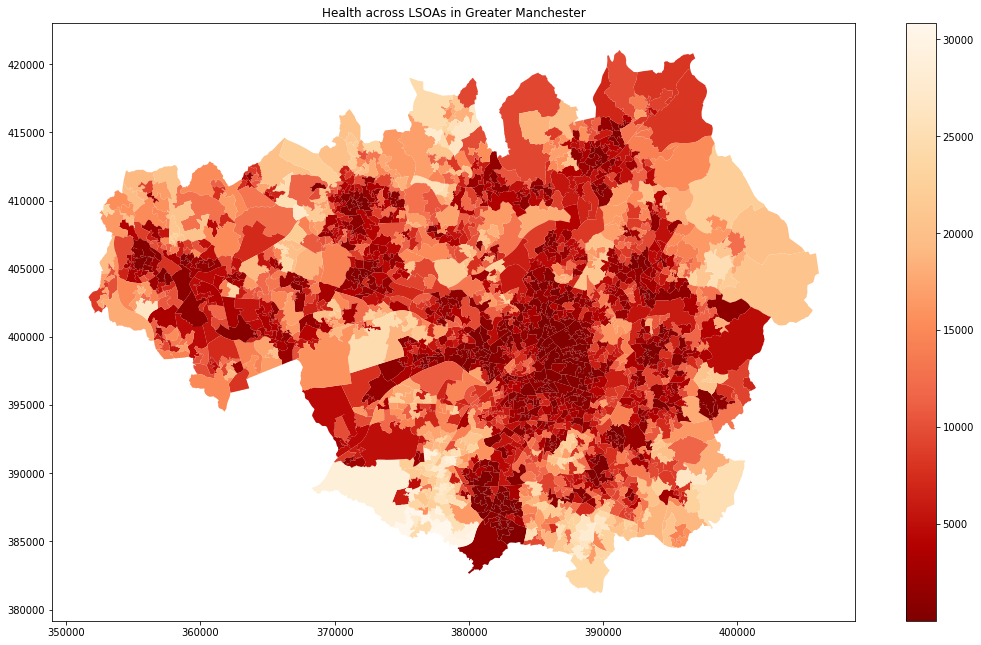

In [7]:
#Chloropleth Map of health across the study area -  
f, ax = plt.subplots(1, figsize=(18,11)); #set the figure size with matplotlib to customise the Geopandas plot
#set health as the column in the geodataframe to use for the colour range in the chloropleth map
map.plot(column='health_r', \
        #choose the colour scheme (appending '_r' to the end reverses it)
         cmap='OrRd_r', \
        #set the legend 
         legend=True, ax=ax);
#give the figure a title
plt.title("Health across LSOAs in Greater Manchester"); 
#plot the figure
plt.figure(); 

A distinct overall trend of lower values for health can be seen around inner-city LSOAs, but it is not restricted to these areas. We will explore some of the factors that may be influencing this by examining another source of data.

### 2.1 Access to Healthy Assets and Hazards data
The Access to Healthy Assets and Hazards (AHAH) dataset holds information about LSOA characteristics in terms of the acessibility of health assets such as GP surgeries, dentists and leisure centres, as well as potential health risks such as off-licenses and fast food outlets. The variables below will be used in our models.

Mean distance to travel to -
* fast food outlets `ffood_d`
* GP surgeries `gpp_d`

Air pollution -
* NO<sub>2</sub> annual mean in µg/m<sup>3</sup> `no2`
* SO<sub>2</sub> annual mean in µg/m<sup>3</sup> `so2`
* PM<sub>10</sub> annual mean in µg/m<sup>3</sup> `pm10`

Metadata for how these variables are measured is available on the [CDRC website](https://data.cdrc.ac.uk/dataset/d6108ce1-c564-471c-bd4c-856aeaf08aad/resource/3bb76178-8ee4-47b4-9875-38b1cb0206df/download/ahahinputscomponentsmetadata.html).

As the AHAH dataset is contained in a CSV file, we can open it using pandas.

In [8]:
#Open the AHAH data frame in pandas
df = pd.read_csv('ahahinputs.csv')

Again, we check the numbers of variables and observations in the dataframe.

In [9]:
#Return the number of rows and columns within the dataframe
df.shape

(41729, 30)

The AHAH inputs dataframe contains data on all the LSOAs in England, Wales and Scotland; many more rows than the geodataframe of LSOAs in Greater Manchester. The variables within the dataframe can be seen by again using the `.info()` command, again passing the optional argument `null_counts=True` to check for missing values.

In [10]:
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41729 entries, 0 to 41728
Data columns (total 30 columns):
seqnum             41729 non-null int64
lsoa11             41729 non-null object
gamb_d             41729 non-null float64
ffood_d            41729 non-null float64
pubs2_d            41729 non-null float64
off2_d             41729 non-null float64
tobac_d            41729 non-null float64
gpp_d              41729 non-null float64
ed_d               41729 non-null float64
dent_d             41729 non-null float64
pharm_d            41729 non-null float64
leis_d             41729 non-null float64
no2                41729 non-null float64
pm10               41729 non-null float64
so2                41729 non-null float64
green900           41729 non-null float64
gamb_decile        41729 non-null int64
ffood_decile       41729 non-null int64
pubs2_decile       41729 non-null int64
off2_decile        41729 non-null int64
tobac_decile       41729 non-null int64
gpp_decile         417

As with the IMD data, we will check the first few rows in the new dataframe to see what kind of values they hold.

In [11]:
#Check what is contained in the first 5 rows of the AHAH file
df.head()

,seqnum,lsoa11,gamb_d,ffood_d,pubs2_d,off2_d,tobac_d,gpp_d,ed_d,dent_d,...,tobac_decile,gpp_decile,ed_decile,dent_decile,pharm_decile,leis_decile,no2_decile,pm10_decile,so2_decile,green900_decile
0,1,W01000934,0.848966,0.272759,0.365172,0.864828,1.472069,1.019655,15.028621,0.964138,...,8,5,8,5,4,2,3,4,7,6
1,2,E01015190,3.291429,1.792381,2.917619,2.341667,3.203095,2.189762,9.845714,2.508095,...,5,9,7,9,9,7,1,4,4,9
2,3,E01007121,0.661818,1.327273,2.865758,0.667273,2.980303,2.355152,5.736636,2.324242,...,6,9,4,9,4,6,6,3,9,2
3,4,W01001937,9.938169,9.715775,9.626197,71.704225,9.942254,1.890282,9.230225,9.835352,...,2,8,6,10,9,10,1,2,1,8
4,5,W01000740,1.085357,3.114286,2.416071,3.921071,4.044286,1.741786,10.198214,1.213214,...,4,8,7,6,8,6,3,3,6,10


### 2.2 Combining the data sources

We now need to combine the two data sources into a single geodataframe. Before we can do this however, we'll need to rename the LSOA variable in the AHAH dataframe to the same as the IMD geodataframe so that it can act as a linking unique identifer variable across both dataframes.

In [12]:
#Rename the lsoa variable in the AHAH dataframe to the same format as AHAH gdf
df = df.rename(columns={'lsoa11': 'lsoa11cd'})

#Check it worked by checking the list of variables in the dataframe
list(df)

['seqnum',
 'lsoa11cd',
 'gamb_d',
 'ffood_d',
 'pubs2_d',
 'off2_d',
 'tobac_d',
 'gpp_d',
 'ed_d',
 'dent_d',
 'pharm_d',
 'leis_d',
 'no2',
 'pm10',
 'so2',
 'green900',
 'gamb_decile',
 'ffood_decile',
 'pubs2_decile',
 'off2_decile',
 'tobac_decile',
 'gpp_decile',
 'ed_decile',
 'dent_decile',
 'pharm_decile',
 'leis_decile',
 'no2_decile',
 'pm10_decile',
 'so2_decile',
 'green900_decile']

We can now merge the two data sources. By choosing the IMD data as the first point in the merge, the only LSOAs from the AHAH dataset joined with it are ones in the Greater Manchester area.

In [13]:
#Merge the df with the gdf based on the unique identifier 'lsoa11cd'
DFmap = map.merge(df, on='lsoa11cd')

We can check that new columns have been added to the LSOAs:

In [14]:
#Check the merge has added the new columns.
list(DFmap)

['lsoa11cd',
 'imd_r',
 'imd_d',
 'income_r',
 'income_d',
 'empl_r',
 'empl_d',
 'educ_r',
 'educ_d',
 'health_r',
 'health_d',
 'crime_r',
 'crime_d',
 'housing_r',
 'housing_d',
 'l_env_r',
 'l_env_d',
 'geometry',
 'seqnum',
 'gamb_d',
 'ffood_d',
 'pubs2_d',
 'off2_d',
 'tobac_d',
 'gpp_d',
 'ed_d',
 'dent_d',
 'pharm_d',
 'leis_d',
 'no2',
 'pm10',
 'so2',
 'green900',
 'gamb_decile',
 'ffood_decile',
 'pubs2_decile',
 'off2_decile',
 'tobac_decile',
 'gpp_decile',
 'ed_decile',
 'dent_decile',
 'pharm_decile',
 'leis_decile',
 'no2_decile',
 'pm10_decile',
 'so2_decile',
 'green900_decile']

## 3.0 Data Exploration
We can examine descriptive statistics of the combined dataset with pandas `.describe()` command.

In [15]:
DFmap.describe()

,imd_r,imd_d,income_r,income_d,empl_r,empl_d,educ_r,educ_d,health_r,health_d,...,tobac_decile,gpp_decile,ed_decile,dent_decile,pharm_decile,leis_decile,no2_decile,pm10_decile,so2_decile,green900_decile
count,1673.000000,1673.000000,1673.000000,1673.000000,1673.000000,1673.000000,1673.000000,1673.000000,1673.000000,1673.000000,...,1673.000000,1673.000000,1673.000000,1673.000000,1673.000000,1673.000000,1673.000000,1673.000000,1673.000000,1673.000000
mean,13054.302451,4.494919,13594.780634,4.646742,12369.653915,4.285117,14808.809922,5.011955,8645.722654,3.181112,...,7.408846,4.451883,3.749552,4.309026,4.494919,4.833831,7.835625,4.335326,9.173939,5.573222
std,9785.608609,2.958869,9982.053721,3.018110,9269.526000,2.794496,10000.583882,3.017469,7330.098243,2.208634,...,1.974471,2.439750,1.821926,2.304462,2.470424,2.265273,1.095280,0.709169,0.641648,2.762670
min,32.000000,1.000000,40.000000,1.000000,8.000000,1.000000,26.000000,1.000000,10.000000,1.000000,...,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,3.000000,8.000000,1.000000
25%,4139.000000,2.000000,4469.000000,2.000000,3937.000000,2.000000,5844.000000,2.000000,2316.000000,1.000000,...,6.000000,2.000000,2.000000,2.000000,2.000000,3.000000,7.000000,4.000000,9.000000,3.000000
50%,11137.000000,4.000000,11969.000000,4.000000,10809.000000,4.000000,13270.000000,5.000000,6532.000000,2.000000,...,8.000000,4.000000,4.000000,4.000000,4.000000,5.000000,8.000000,4.000000,9.000000,5.000000
75%,21548.000000,7.000000,22212.000000,7.000000,19755.000000,7.000000,23779.000000,8.000000,14063.000000,5.000000,...,9.000000,6.000000,5.000000,6.000000,7.000000,7.000000,9.000000,5.000000,10.000000,8.000000
max,32769.000000,10.000000,32832.000000,10.000000,32833.000000,10.000000,32816.000000,10.000000,30848.000000,10.000000,...,10.000000,10.000000,8.000000,10.000000,10.000000,10.000000,10.000000,6.000000,10.000000,10.000000


We could hypothesise that increased access to fast food may have a negative effect on health. Let's plot the spatial distribution of this variable.

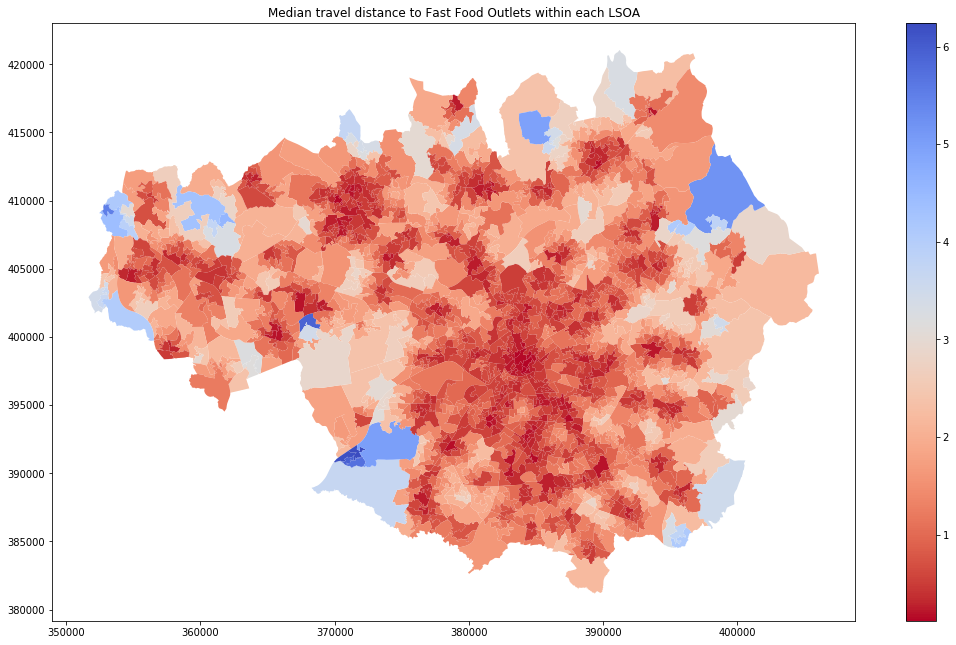

In [16]:
#set figure size  
f, ax = plt.subplots(1, figsize=(18, 11));
#select ffood_d as the variable of interest, set the colour scheme and the legend 
DFmap.plot(column='ffood_d', cmap='coolwarm_r', legend=True, ax=ax); #appending '_r' to a cmap reverses it
#set the title
plt.title('Median travel distance to Fast Food Outlets within each LSOA');
#plot the figure
plt.figure();

Air pollution is a well-known cause of respiratory and cardiovascular problems as well as contributing to an increased risk of mental disorders ([Vert *et al.*, 2017](https://doi.org/10.1016/j.ijheh.2017.06.009.)). Nitrous dioxide will be one of the independent variables we will be using to predict health across the study area, so it will be useful to gain an idea of NO<sub>2</sub> distribution across Greater Manchester.

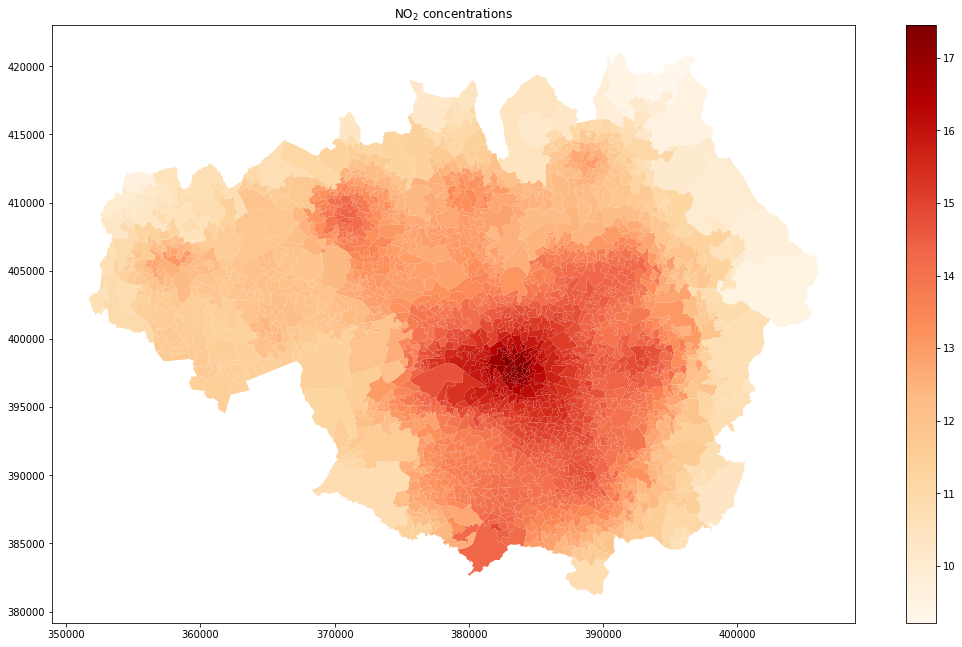

In [17]:
#Chloropleth Map of NO2 -  
f, ax = plt.subplots(1, figsize=(18, 11));
DFmap.plot(column='no2', cmap='OrRd', legend=True, ax=ax);
plt.title('$\mathregular{NO_2}$ concentrations'); 
plt.figure();

NO<sub>2</sub> concentrations appear highest around Manchester city centre. [PM<sub>10</sub> ](https://uk-air.defra.gov.uk/assets/documents/reports/aqeg/pm-summary.pdf) is also a cause of many health issues, so will be another variable we'll be using in our models.

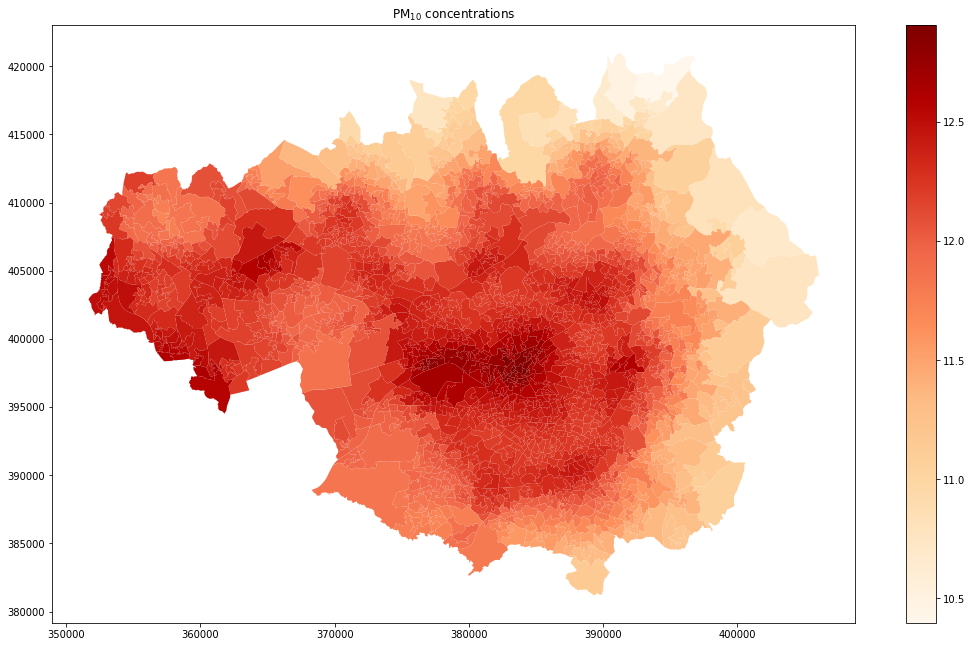

In [18]:
#Set the figure size  
f, ax = plt.subplots(1, figsize=(18, 11));
#Select pm10 as the mapped variable, set the colour map, and set the legend
DFmap.plot(column='pm10', cmap='OrRd', legend=True, ax=ax);
#Set the title. '\mathregular' sets to normal font, _{..} sets multiple digit subscript
plt.title('$\mathregular{PM_{10}}$ concentrations'); 
#plot the figure
plt.figure();

One of the main sources of PM<sub>10</sub> is road traffic, and higher concentrations in the LSOAs around the Manchester ring road are clearly visible in the above image.

SO<sub>2</sub> is the last pollutant we'll be looking at, which appears highly concentrated in relatively small sections of the study area.

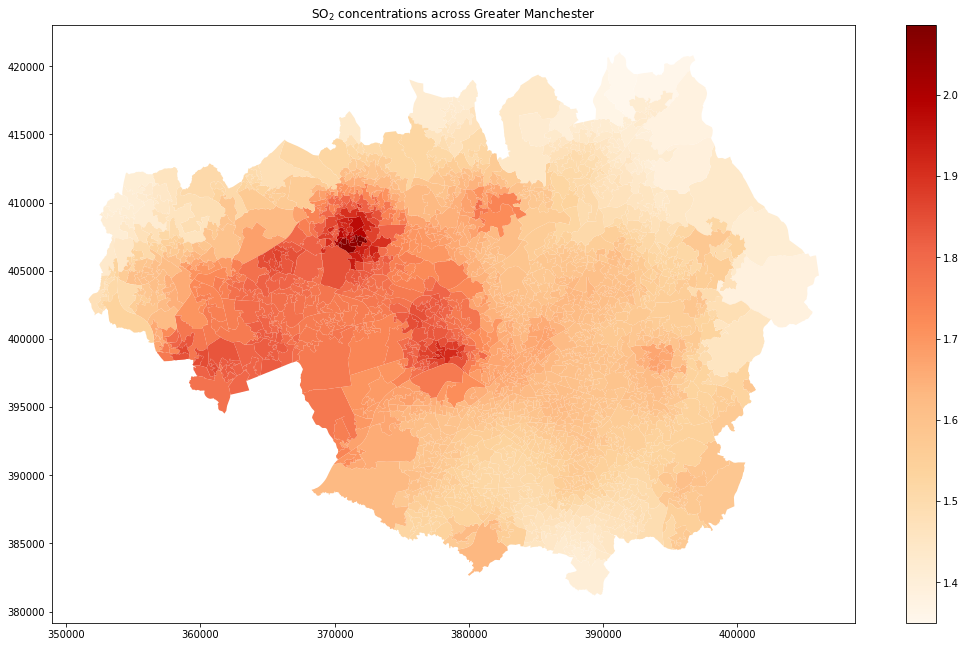

In [19]:
#Set the figure size
f, ax = plt.subplots(1, figsize=(18, 11));
#Select so2 as the mapped variable, set the colour map, and set the legend
DFmap.plot(column='so2', cmap='OrRd', legend=True, ax=ax);
#Set the figure title (\mathregular sets to normal font with subscript)
plt.title('$\mathregular{SO_2}$ concentrations across Greater Manchester'); #\mathregular sets to normal font
#plot the figure
plt.figure();

### 3.1 Standardising and Centring Data

Standardising and centreing input variables can aid the interpretation of regression coefficients ([Schielzeth, 2010](https://doi.org/10.1111/j.2041-210X.2010.00012.x)). When standardised, the intercept term should be interpreted as the expected value of Y when the independent variables are at their means, rather than zero, which may be an unrealistic scenario. Another advantage is that when standardised, the units of the regression coefficients are all the same, and thus directly comparible, even if the original numeric ranges of the independent variables may be different orders of magnitude. This aids interpretation of the predictive importance of each variable.

In [20]:
#First drop the na values from the features of interest
vars = ['pm10', 'no2', 'so2', 'ffood_d', 'health_r', 'gpp_d']
features = DFmap[vars].dropna()

In [21]:
#scale and centre the features via scikit-learn's preprocessing function
features_std = pd.DataFrame(preprocessing.scale(features),
                           index=features.index,
                           columns=features.columns)

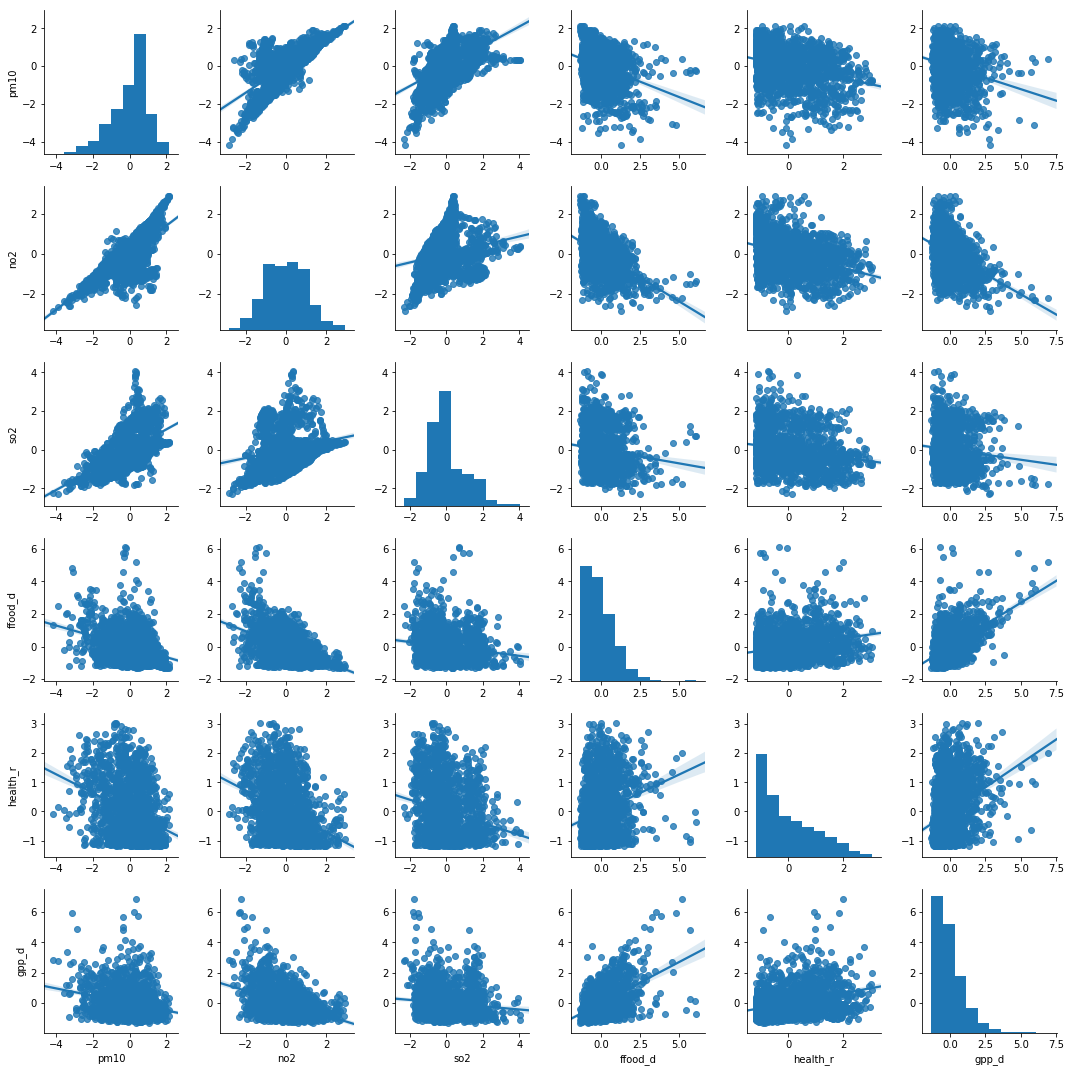

In [22]:
#compare correlation across variables with using Seaborn's pairplot function
sns.pairplot(features_std, kind='reg');

Pairplots can be an efficient way of seeing how variables relate to each other and as a preliminary check for multicollinearity issues.

## 4.0 Clustering

K-means clustering is an iterative algorithm which places each observation into one of *K* classes based on feature similarity and thus can be useful for identifying latent classes within complex data. The algorithm works by iteratively moving a set number of cluster centroids around the feature space seeking to minimise the squared euclidean distance between the centroids and the data points which are nearest to them.  

### 4.1 Determining the optimum number of clusters

One method of selecting the optimum number of clusters to use is by measuring inertia. Inertia can be defined as the total squared distances to the closest centroid for all the observations in the data set (see the [Scikit-learn documentation](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.k_means.html) for further details).

In order to determine the optimum number of clusters to use, i.e. the minimum amount that provides the lowest inertia per cluster, we will loop through a range of cluster sizes and measure the inertia each time.

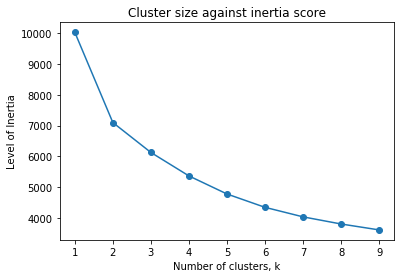

In [23]:
#Assess how many clusters to use by measuring the inertia of different cluster sizes with the standardised data

clusterList = range(1, 10) #Set the range of cluster sizes to loop through
inertias = [] #Create an empty array to store the inertia of each cluster size in

for k in clusterList: #Loop through the different cluster sizes
    model = cluster.KMeans(n_clusters = k) #Create a KMeans instance where the n of clusters = n of each iteration        
    model.fit(features_std) #fit the model to the standardised data        
    inertias.append(model.inertia_) #append the inertia for each model to the 'inertias' array
    
#Set a line plot of the clusters against inertia scores-
plt.plot(clusterList, inertias, '-o'); #'-o' sets a marker at each point on the line.
plt.xlabel('Number of clusters, k'); #Set the x axis title
plt.ylabel('Level of Inertia'); #Set the y axis title
plt.xticks(clusterList); #Set the X axis labels
plt.title('Cluster size against inertia score') #Set the plot title
plt.show(); #Display the plot

While the largest drop in inertia occurs between 1 and 2 clusters, arguably the reduction levels out after 5 clusters, with each additional cluster only reduces the level of inertia by a very small amount. This indicates that a 5 cluster fit may be the most parsimonius. 

### 4.2 Fitting the standardised features to the clusters

In [37]:
#Fit a 5 cluster KMeans model to the standardised data
model = cluster.KMeans(n_clusters = 5)
km5cls = model.fit(features_std) 

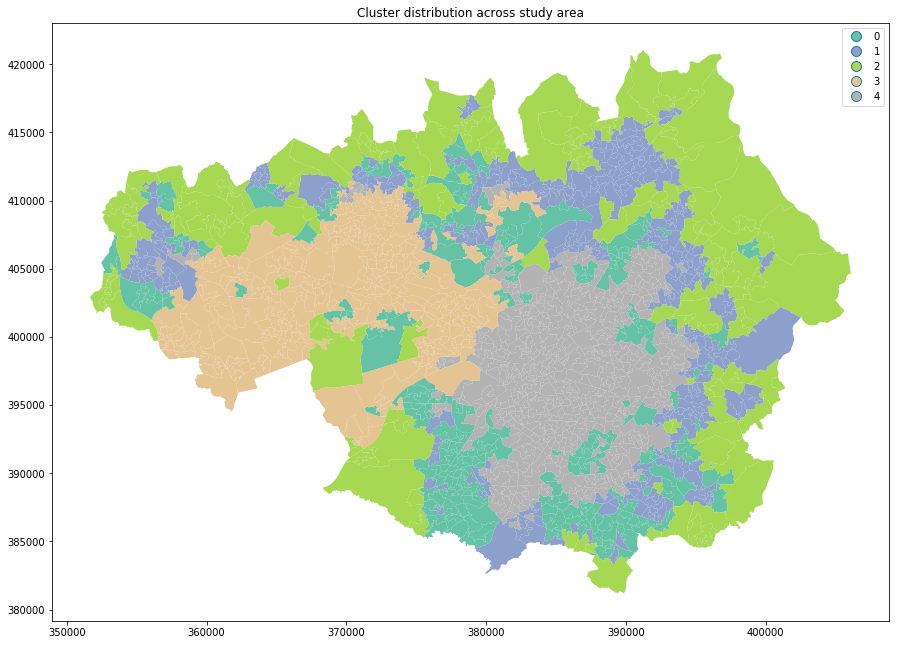

In [38]:
f, ax = plt.subplots(1, figsize=(15, 11));
#Attach the cluster labels to each observation in the geodataframe
#attach and set Cluster as a categorical variable for the map, set the colour scheme, and set the legend
DFmap.assign(Cluster=km5cls.labels_).plot(column='Cluster', categorical=True, cmap='Set2', legend=True, ax=ax);
#set the title
plt.title('Cluster distribution across study area');
#plot the figure
plt.show();

The clusters appear to show a strong spatial correlation, with cluster 1 concentrated around the inner city, 4 the less urban outskirts of the study area, 3 to the west and 0 and 2 more suburban or industrial areas.

In [39]:
#Append cluster labels to standardised variables
ClustStand = features_std.assign(Cluster=km5cls.labels_)

We can attach these cluster labels to our geodataframe and look at how the variables we'll be using in our models variables vary across clusters.

In [40]:
#Attach the cluster labels to each observation in the GDF
ClustDF = DFmap.assign(Cluster=km5cls.labels_)

In [41]:
ClustStand.groupby('Cluster').mean().T

Cluster,0,1,2,3,4
pm10,-0.231879,-0.766283,-1.339607,0.480213,0.741413
no2,-0.159943,-0.550258,-1.341937,-0.316345,1.032551
so2,-0.360482,-0.612690,-0.841638,1.557777,-0.068954
ffood_d,0.102586,-0.148525,1.778129,0.023734,-0.528463
health_r,1.434673,-0.449990,0.749614,-0.210985,-0.598862
gpp_d,0.170468,-0.258230,1.601954,0.069567,-0.468133


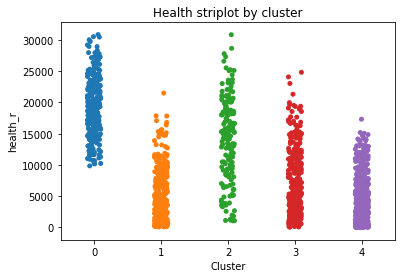

In [42]:
sns.stripplot(x='Cluster', y='health_r', data=ClustDF, jitter=True);
plt.title('Health striplot by cluster');
plt.figure();

- Cluster 0 has the highest mean health score, along with lower than average air pollution, though not the lowest.
- Cluster 1 has the 2nd lowest mean health score, despite relatively low air pollution. Low access to GPs and fast food may be indicative of economic deprivation.
- Cluster 2 has relatively low mean air pollution, high access to GP surgeries and fast food, and the second highest mean health score.
- Cluster 3 has the highest SO<sub>2</sub> of the clusters, and the 2nd highest mean PM<sub>10</sub> level.
- Cluster 4 appears to have the highest mean NO<sub>2</sub> and PM<sub>10</sub>, the lowest mean access to GP surgerys and the lowest mean health score.

## 5.0 Regression Models

### 5.1 Unvalidated regression
First we will apply linear regression to examine the relationships between our covariates and the dependent variable.

In [43]:
#Statsmodels OLS regression
m1 = sm.ols('health_r ~ ffood_d + pm10 + no2 + so2', features_std).fit()
m1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               health_r   R-squared:                       0.153
Model:                            OLS   Adj. R-squared:                  0.151
Method:                 Least Squares   F-statistic:                     75.45
Date:                Tue, 28 Aug 2018   Prob (F-statistic):           7.52e-59
Time:                        15:48:21   Log-Likelihood:                -2234.8
No. Observations:                1673   AIC:                             4480.
Df Residuals:                    1668   BIC:                             4507.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -4.163e-17      0.023  -1.85e-15      1.000      -0.044       0.044
ffood_d        0.1000      0.026      3.895      0.000       0.050       0.150
pm10          -0.0582      0.038     -1.545      0.122      -0.132       0.016
no2           -0.2481      0.035     -7.025      0.000      -0.317      -0.179
so2           -0.1019      0.027     -3.717      0.000      -0.156      -0.048
==============================================================================
Omnibus:                      106.807   Durbin-Watson:                   0.968
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              126.426
Skew:                           0.669   Prob(JB):                     3.52e-28
Kurtosis:                       2.842   Cond. No.                         3.31
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

This model has an R<sup>2</sup> of 0.153, meaning it explains ~15% of the variance observed. The coefficients show that `ffood_d` appears to be associated with a small positive increase in health. Rather than a sign that contrary to accepted guidelines, fast food is actually good for people's health, this could be due to `ffood_d` acting as a proxy for a latent factor such as relative affluence, or a skew towards a younger population who have yet to develop health problems associated with later life. 

`no2` has the largest negative coefficient (-0.248), indicating a strong detrimental association with health as concentration increases. `so2`'s coefficient is smaller (-0.102) but still significantly detrimental.

`pm10` appears to have a small negative relationship with health, though the p value of 0.122 indicates that this is not statistically significant at the 95% confidence level.

### 5.2 Comparison of modelled and observed distribution
We can visualise the distribution of values of a model to inspect how well it fits with the observed data.

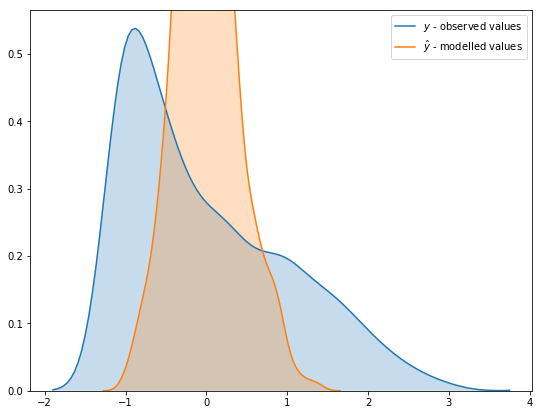

In [44]:
#set the figure size
f, ax = plt.subplots(1, figsize=(9, 7))
#plot the actual values
sns.kdeplot(features_std['health_r'], shade=True, ax=ax, label='$y$ - observed values')
#plot the modelled values
sns.kdeplot(m1.fittedvalues, shade=True, ax=ax, label='$\hat{y}$ - modelled values')
plt.show()

The model is currently producing a roughly normal distribution around the mean, failing to capture the skew to lower values and the long tail towards higher values. 

Let's add another variable - `gpp_d` - access to GP surgeries.

In [45]:
#Statsmodels OLS regression - this time with gpp_d added
m2 = sm.ols('health_r ~ ffood_d + so2 + no2 + gpp_d + pm10', ClustStand).fit() #ClustStand
m2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               health_r   R-squared:                       0.186
Model:                            OLS   Adj. R-squared:                  0.183
Method:                 Least Squares   F-statistic:                     76.15
Date:                Tue, 28 Aug 2018   Prob (F-statistic):           5.05e-72
Time:                        15:48:49   Log-Likelihood:                -2201.8
No. Observations:                1673   AIC:                             4416.
Df Residuals:                    1667   BIC:                             4448.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -4.163e-17      0.022  -1.88e-15      1.000      -0.043       0.043
ffood_d        0.0025      0.028      0.090      0.928      -0.052       0.057
so2           -0.0929      0.027     -3.451      0.001      -0.146      -0.040
no2           -0.1905      0.035     -5.389      0.000      -0.260      -0.121
gpp_d          0.2199      0.027      8.186      0.000       0.167       0.273
pm10          -0.0818      0.037     -2.206      0.028      -0.154      -0.009
==============================================================================
Omnibus:                      114.481   Durbin-Watson:                   0.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              138.187
Skew:                           0.704   Prob(JB):                     9.84e-31
Kurtosis:                       2.970   Cond. No.                         3.54
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [46]:
# Compare the R^2 values
r2 = pd.Series({'Enhanced linear model R^2': metrics.r2_score(features_std['health_r'],
                                              m2.fittedvalues),
                'Baseline linear model R^2': metrics.r2_score(features_std['health_r'],
                                              m1.fittedvalues)})
r2

Baseline linear model R^2    0.153207
Enhanced linear model R^2    0.185929
dtype: float64

As expected, increased access to GP surgeries has a significant beneficial relationship with better health. The model R<sup>2</sup> is now slightly better - from 0.153 to 0.186, meaning now almost 19% of the variance is explained. Let's compare the plots again.

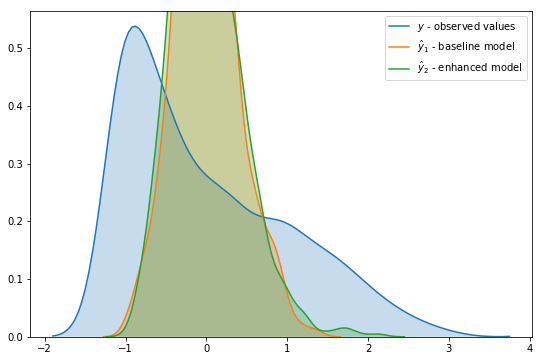

In [47]:
#Plot the data against the 2 models - adding gpp_d has marginally improved the accuracy of the model at higher values.
#set the axis
f, ax = plt.subplots(1, figsize=(9, 6))
#plot the observed values
sns.kdeplot(features_std['health_r'], shade=True, ax=ax, label='$y$ - observed values')
#plot the baseline model values
sns.kdeplot(m1.fittedvalues, shade=True, ax=ax, label='$\hat{y}_1$ - baseline model')
#plot the enhanced model values
sns.kdeplot(m2.fittedvalues, shade=True, ax=ax, label='$\hat{y}_2$ - enhanced model')
#plot the figure
plt.show()

### 5.2 Cross-validated regression

When building regression models, it is common to find a relationship that has a strong predictive capacity on the dataset in question due to over-fitting, but cannot be replicated when used on other data sources. In order test a model more objectively, it can be of benefit to split the data into training and test data, train the model on one part of the data set and then compare its results when used on another part of the data.

In [48]:
#Set the independent vars for use in the model
IndVars = ['no2', 'pm10', 'so2', 'ffood_d', 'gpp_d']

In [57]:
#Split the data into train and test data using scikit-learn's train_test_split function
x_train, x_test, y_train, y_test = model_selection.train_test_split(ClustStand[IndVars], 
                                                                    ClustStand['health_r'],
                                                                    test_size=0.2)

In [58]:
#Train the model on the training split of the data
Vars = 'health_r ~ no2 + so2 + ffood_d + gpp_d + pm10'
m1_tr = sm.ols(Vars, x_train.assign(health_r=y_train)).fit()

In [67]:
#Test the model on the test data
M1_test = m1_tr.predict(x_test)

It's useful to compare parameters at this stage to see if the reduced data the model has been trained on has changed its characteristics.

In [64]:
#plot a dataframe to compare model parameters rounded to 4 decimal places
pd.DataFrame({'Full Dataset': m2.params.round(4),
              'Training Set': m1_tr.params.round(4)})

,Full Dataset,Training Set
Intercept,-0.0000,-0.0067
ffood_d,0.0025,0.0061
gpp_d,0.2199,0.2080
no2,-0.1905,-0.1898
pm10,-0.0818,-0.0613
so2,-0.0929,-0.1144


The beta coefficients in the models vary slightly due to differences in the data they have been trained on, but are largely similar. We can test if the model has lost predictive power as a result by comparing the R<sup>2</sup> values.

In [68]:
#create a pandas series of the two models R2 values    
pd.Series({'Model with Full Dataset': m2.rsquared,
           'Model with 80% training data': m1_tr.rsquared})

Model with 80% training data    0.173362
Model with Full Dataset         0.185929
dtype: float64

The R<sup>2</sup> has dropped slightly for the model trained on 80% of the data compared to the full set, but only by a very small amount. As shown in the figure below, the cross-validated model results are very similar to the ones from the full dataset.

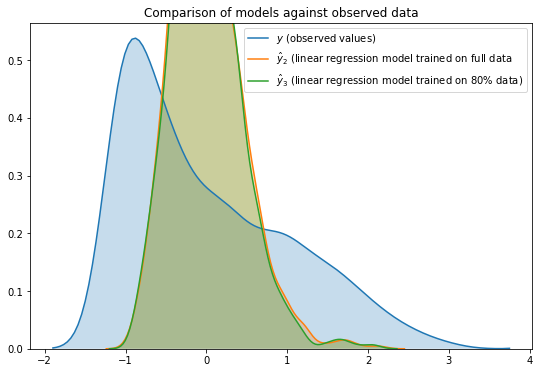

In [69]:
#Plot the data against the 2 models 
f, ax = plt.subplots(1, figsize=(9, 6))
sns.kdeplot(ClustStand['health_r'], shade=True, ax=ax, label='$y$ (observed values)')
sns.kdeplot(m2.fittedvalues, shade=True, ax=ax, label='$\hat{y}_2$ (linear regression model trained on full data')
sns.kdeplot(m1_tr.fittedvalues, shade=True, ax=ax, label='$\hat{y}_3$ (linear regression model trained on 80% data)')
plt.title('Comparison of models against observed data')
plt.show()

## 6.0 Further Work

### 6.1 Random Forest Regression 

To improvement our model we will try a different technique. Random forest regression is a decision tree ensemble approach which has demonstrated strong predictive capacities in many studies, out-performing both linear regresion and artificial neural network methods when modelling air quality in urban areas ([Segal, 2004](https://escholarship.org/uc/item/35x3v9t4); [Karatzas *et al*., 2017](https://doi.org/10.1007/978-3-319-54430-4_52)). In random forest regression, a number of decision 'trees' are grown based on a random subset of the independent variables, on bootstrapped (i.e. resampling is allowed) samples taken from the training data. These decision trees are combined into an ensemble, and independent variables are assigned an importance score for their contribution to predictive accuracy. Generally the higher the number of trees specified, the more accurate the model but the greater computing power required, however a point is usually reached where adding extra trees does not increase the accuracy any further.

In [70]:
# Set random seed for replicable results
np.random.seed(3)

#Specify the independent variables to be used in the Random Forest Regressor
cols = ['ffood_d','so2','no2', 'pm10', 'gpp_d']

In [72]:
#Randomly split the independent variables and the dependent variable into 80% train and 20% test data
RFx_train, RFx_test, RFy_train, RFy_test = model_selection.train_test_split(ClustStand[cols], 
                                                                    ClustStand['health_r'],
                                                                    test_size=0.2)

#Train the model on the training data set. Set the number of estimators to 2000 to enhance model stability. 
RFR = RandomForestRegressor(n_estimators=2000).fit(RFx_train, RFy_train)
#run the model on the test data
m5 = RFR.predict(RFx_test)

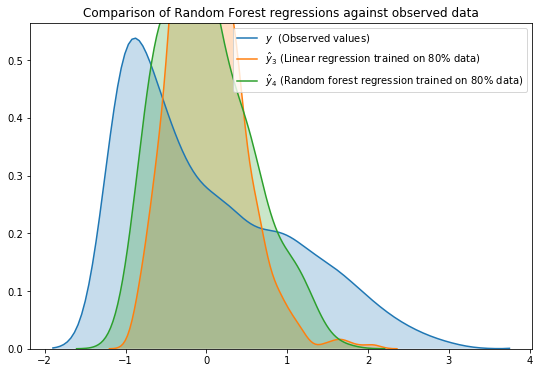

In [73]:
#set the figure size
f, ax = plt.subplots(1, figsize=(9, 6))
#plot the observed values distribution
sns.kdeplot(ClustStand['health_r'], shade=True, ax=ax, label='$y$  (Observed values)')
#plot the linear regression model distribution
sns.kdeplot(m1_tr.fittedvalues, shade=True, ax=ax, label='$\hat{y}_3$ (Linear regression trained on 80% data)')
#plot the RFR model distribution
sns.kdeplot(m5, shade=True, ax=ax, label='$\hat{y}_4$ (Random forest regression trained on 80% data)')
#set the title
plt.title('Comparison of Random Forest regressions against observed data')
#plot the figure
plt.show()

The Random Forest Regressor appears to have improved on distribution of the linear regression model slightly, with better representation of the overall shape of the data. 

### 6.3 Predictive importance of variables
We can examine the predictive importance of the variables and compare with the beta coefficients from the regression models.

In [74]:
#Print a dataframe of the relative importance of the predictor variables.
Predictives = pd.DataFrame({'Variable': cols, 'Predictive importance': RFR.feature_importances_.round(2)})
#sort the values by their predictive importance
Predictives = Predictives.sort_values(by='Predictive importance', ascending=False)
Predictives

,Predictive importance,Variable
2,0.25,no2
4,0.23,gpp_d
1,0.19,so2
3,0.17,pm10
0,0.15,ffood_d


In the random forest algorithm, the input variables are not given positive or negative coefficients but their predictive importance appears to follow a similar pattern to the size of the linear regression coefficients.

### 6.2 Evaluation and comparison of modelling approaches
As a final comparison of models, we can compare their R<sup>2</sup>, mean squared error and mean absolute error values.

In [75]:
# Test
test_pred = m1_tr.params['Intercept'] + \
            x_test.dot(m1_tr.params.drop('Intercept'))

r2 = pd.Series({'Unvalidated linear regression': metrics.r2_score(ClustStand['health_r'], m2.fittedvalues),
                'Cross-validated linear regression (80/20 train/test)': metrics.r2_score(y_test, test_pred), 
                'Random forest regressor (80/20 train/test)': metrics.r2_score(RFy_test, m5)})

# MSE
mse = pd.Series({'Unvalidated linear regression': metrics.mean_squared_error(ClustStand['health_r'], m2.fittedvalues),
                 'Cross-validated linear regression (80/20 train/test)': metrics.mean_squared_error(y_test, test_pred),
                 'Random forest regressor (80/20 train/test)': metrics.mean_squared_error(RFy_test, m5)});

# Mean Absolute Error
mae = pd.Series({'Unvalidated linear regression': metrics.mean_absolute_error(ClustStand['health_r'], m2.fittedvalues),
                 'Cross-validated linear regression (80/20 train/test)': metrics.mean_absolute_error(y_test, test_pred),
                 'Random forest regressor (80/20 train/test)': metrics.mean_absolute_error(RFy_test, m5)});

In [76]:
#Build a dataframe of the model performance across several metrics as defined in the previous cell
FullComp = pd.DataFrame({'MAE': mae,
                     'MSE': mse,
                     '$R^2$': r2})
FullComp = FullComp.sort_values(by='$R^2$', ascending=False)
FullComp.round(2)

,$R^2$,MAE,MSE
Random forest regressor (80/20 train/test),0.26,0.74,0.83
Cross-validated linear regression (80/20 train/test),0.23,0.69,0.73
Unvalidated linear regression,0.19,0.73,0.81


## 7.0 References

Daras, K., Green, M.A., Davies, A., Singleton, A. & Barr, B. (2017). Access to Healthy Assets and Hazards (AHAH). DOI:10.13140/RG.2.2.11939.66083. Available at:
[https://www.researchgate.net/publication/318039690_Access_to_Healthy_Assets_and_Hazards_AHAH](https://www.researchgate.net/publication/318039690_Access_to_Healthy_Assets_and_Hazards_AHAH) [Accessed 17 April 2018]

Karatzas, K., Katsifarakis, N., Orlowski, C. and Sarzyński, A., (2017). Urban Air Quality Forecasting: A Regression and a Classification Approach. *Asian Conference on Intelligent Information and Database Systems*, Springer International Publishing, pp. 539-548. [https://doi.org/10.1007/978-3-319-54430-4_52](https://doi.org/10.1007/978-3-319-54430-4_52)  

Schielzeth, H., (2010). Simple means to improve the interpretability of regression coefficients. *Methods in Ecology and Evolution*, 1(2), pp.103-113. [https://doi.org/10.1111/j.2041-210X.2010.00012.x](https://doi.org/10.1111/j.2041-210X.2010.00012.x)

Segal, M. R. (2004). Machine Learning Benchmarks and Random Forest Regression. *UCSF: Center for Bioinformatics and Molecular Biostatistics*. Available at [https://escholarship.org/uc/item/35x3v9t4](https://escholarship.org/uc/item/35x3v9t4) [Accessed 27 April 2018].

Smith, T., Noble, M., Noble, S., Wright, G., McLennan, D., Plunkett, E. (2015). The English Indices of
Deprivation 2015, Department for Communities and Local Government. Available at:
[https://www.gov.uk/government/publications/english-indices-of-deprivation-2015-technical-report](https://www.gov.uk/government/publications/english-indices-of-deprivation-2015-technical-report)
[Accessed 17 April 2018]

Vert, C., Sánchez-Benavides, G., Martínez, D., Gotsens, X., Gramunt, N., Cirach, M., Molinuevo, J.L., Sunyer, J., Nieuwenhuijsen, M.J., Crous-Bou, M. and Gascon, M., (2017). Effect of long-term exposure to air pollution on anxiety and depression in adults: a cross-sectional study. *International Journal of Hygiene and Environmental Health*, 220(6), pp.1074-1080. Available at: [https://doi.org/10.1016/j.ijheh.2017.06.009](https://doi.org/10.1016/j.ijheh.2017.06.009) [Accessed 27 April 2018].

